In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

data = pd.read_csv('data/train.csv')

In [41]:
# Drop the ID column
data = data.drop('id', axis=1)

# Convert date to datetime
data['date'] = pd.to_datetime(data['date'])

# Extract date components
data['day'] = data['date'].dt.day
data['month'] = data['date'].dt.month 
data['year'] = data['date'].dt.year
data['day_of_week'] = data['date'].dt.dayofweek

# Display the first few rows to verify changes
data.head()

,date,country,store,product,num_sold,day,month,year,day_of_week
0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,1,1,2010,4
1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,1,1,2010,4
2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,1,1,2010,4
3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,1,1,2010,4
4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,1,1,2010,4


In [42]:
import requests

def get_gdp_per_capita(alpha3, year):
    url='https://api.worldbank.org/v2/country/{0}/indicator/NY.GDP.PCAP.CD?date={1}&format=json'
    response = requests.get(url.format(alpha3,year)).json()
    return response[1][0]['value']

alpha3s = ['CAN', 'FIN', 'ITA', 'KEN', 'NOR', 'SGP']
data['alpha3'] = data['country'].map(dict(zip(
    np.sort(data['country'].unique()), alpha3s)))
years = np.sort(data['date'].dt.year.unique())
gdp = np.array([
    [get_gdp_per_capita(alpha3, year) for year in years]
    for alpha3 in alpha3s
])
gdp = pd.DataFrame(gdp/gdp.sum(axis=0), index=alpha3s, columns=years)
data['GDP'] = data.apply(lambda s: gdp.loc[s['alpha3'], s['year']], axis=1)


data.drop("alpha3", axis=1, inplace=True)

In [43]:
alpha2 = dict(zip(np.sort(data.country.unique()), ['CA', 'FI', 'IT', 'KE', 'NO', 'SG']))
h = {c: holidays.country_holidays(a, years=range(2010, 2020)) for c, a in alpha2.items()}
data['is_holiday'] = 0
for c in alpha2:
    data.loc[data.country==c, 'is_holiday'] = data.date.isin(h[c]).astype(int)

/var/folders/yh/mm99wdg51z314wrljpx090rm0000gn/T/ipykernel_33905/3460205576.py:5: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  data.loc[data.country==c, 'is_holiday'] = data.date.isin(h[c]).astype(int)
/var/folders/yh/mm99wdg51z314wrljpx090rm0000gn/T/ipykernel_33905/3460205576.py:5: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  data.loc[data.country==c, 'is_holiday'] = data.date.isin(h[c]).astype(int)
/var/folders/yh/mm99wdg51z314wrljpx090rm0000gn/T/ipykernel_33905/3460205576.py:5: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. string

In [44]:
data

,date,country,store,product,num_sold,day,month,year,day_of_week,GDP,is_holiday
0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,1,1,2010,4,0.178301,1
1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,1,1,2010,4,0.178301,1
2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,1,1,2010,4,0.178301,1
3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,1,1,2010,4,0.178301,1
4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,1,1,2010,4,0.178301,1
...,...,...,...,...,...,...,...,...,...,...,...
230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0,31,12,2016,5,0.231100,0
230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0,31,12,2016,5,0.231100,0
230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0,31,12,2016,5,0.231100,0
230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0,31,12,2016,5,0.231100,0


In [45]:
# Label encode categorical columns
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['country', 'store', 'product']
label_encoders = {}

for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    data[col] = label_encoders[col].fit_transform(data[col])

# Display first few rows to verify encoding
data.head()


,date,country,store,product,num_sold,day,month,year,day_of_week,GDP,is_holiday
0,2010-01-01,0,0,0,NaN,1,1,2010,4,0.178301,1
1,2010-01-01,0,0,1,973.0,1,1,2010,4,0.178301,1
2,2010-01-01,0,0,2,906.0,1,1,2010,4,0.178301,1
3,2010-01-01,0,0,3,423.0,1,1,2010,4,0.178301,1
4,2010-01-01,0,0,4,491.0,1,1,2010,4,0.178301,1


In [46]:
data.dropna(inplace=True)

### xgboost



Fold 1 Metrics:
Mean Squared Error: 3754.02
Root Mean Squared Error: 61.27
Mean Absolute Error: 37.56
R-squared Score: 0.99

Fold 2 Metrics:
Mean Squared Error: 3682.56
Root Mean Squared Error: 60.68
Mean Absolute Error: 37.29
R-squared Score: 0.99

Fold 3 Metrics:
Mean Squared Error: 3804.74
Root Mean Squared Error: 61.68
Mean Absolute Error: 37.90
R-squared Score: 0.99

Fold 4 Metrics:
Mean Squared Error: 3867.05
Root Mean Squared Error: 62.19
Mean Absolute Error: 37.73
R-squared Score: 0.99

Fold 5 Metrics:
Mean Squared Error: 3696.52
Root Mean Squared Error: 60.80
Mean Absolute Error: 37.19
R-squared Score: 0.99

Average Metrics Across All Folds:
Mean Squared Error: 3760.98 (+/- 68.58)
Root Mean Squared Error: 61.32 (+/- 0.56)
Mean Absolute Error: 37.53 (+/- 0.27)
R-squared Score: 0.99 (+/- 0.00)


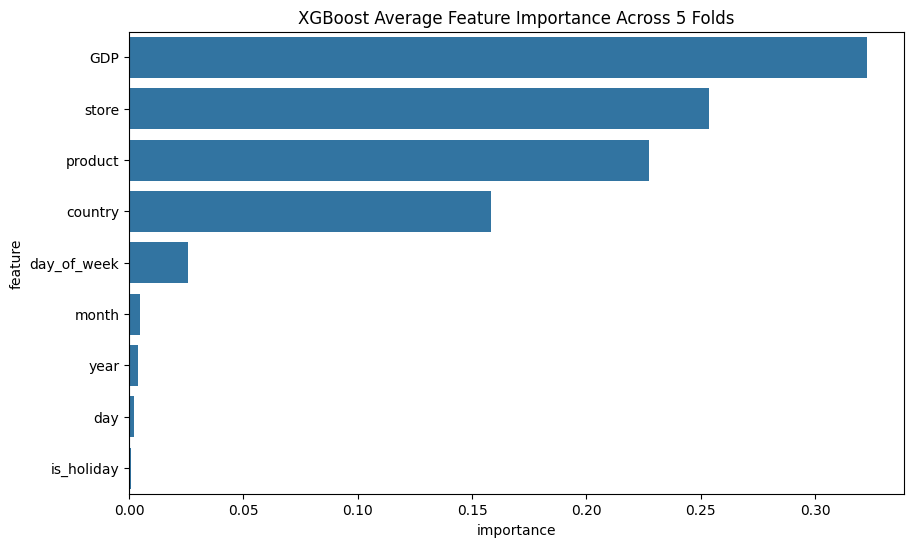

In [47]:
# Split features and target
X = data.drop(['num_sold', 'date'], axis=1)
y = data['num_sold']

# Set up 5-fold cross validation
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
mse_scores = []
rmse_scores = []
mae_scores = []
r2_scores = []
feature_importances = []

# Perform k-fold cross validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Train model
    model = xgb.XGBRegressor(random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_val)
    
    # Calculate metrics
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    # Store metrics
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    feature_importances.append(model.feature_importances_)
    
    print(f"\nFold {fold+1} Metrics:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"R-squared Score: {r2:.2f}")

# Print average metrics across all folds
print("\nAverage Metrics Across All Folds:")
print(f"Mean Squared Error: {np.mean(mse_scores):.2f} (+/- {np.std(mse_scores):.2f})")
print(f"Root Mean Squared Error: {np.mean(rmse_scores):.2f} (+/- {np.std(rmse_scores):.2f})")
print(f"Mean Absolute Error: {np.mean(mae_scores):.2f} (+/- {np.std(mae_scores):.2f})")
print(f"R-squared Score: {np.mean(r2_scores):.2f} (+/- {np.std(r2_scores):.2f})")

# Average feature importance across folds
avg_importance = np.mean(feature_importances, axis=0)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': avg_importance
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('XGBoost Average Feature Importance Across 5 Folds')
plt.show()

In [50]:
# Load test data
test_df = pd.read_csv('data/test.csv')

# Preprocess test data (same transformations as training data)
test_df['date'] = pd.to_datetime(test_df['date'])
test_df['day'] = test_df['date'].dt.day
test_df['month'] = test_df['date'].dt.month 
test_df['year'] = test_df['date'].dt.year
test_df['day_of_week'] = test_df['date'].dt.dayofweek

alpha3s = ['CAN', 'FIN', 'ITA', 'KEN', 'NOR', 'SGP']
test_df['alpha3'] = test_df['country'].map(dict(zip(
    np.sort(test_df['country'].unique()), alpha3s)))
years = np.sort(test_df['date'].dt.year.unique())
gdp = np.array([
    [get_gdp_per_capita(alpha3, year) for year in years]
    for alpha3 in alpha3s
])
gdp = pd.DataFrame(gdp/gdp.sum(axis=0), index=alpha3s, columns=years)
test_df['GDP'] = test_df.apply(lambda s: gdp.loc[s['alpha3'], s['year']], axis=1)
test_df.drop("alpha3", axis=1, inplace=True)

test_df['is_holiday'] = 0
for c in alpha2:
    test_df.loc[test_df.country==c, 'is_holiday'] = test_df.date.isin(h[c]).astype(int)

# Encode categorical columns
categorical_cols = ['country', 'store', 'product']
label_encoders = {}

for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    test_df[col] = label_encoders[col].fit_transform(test_df[col])

# Select features
X_test = test_df.drop(['id', 'date'], axis=1)

# Make predictions
test_predictions = model.predict(X_test)

print("\nFirst few test predictions:")
print(test_predictions[:5])



First few test predictions:
[140.6936  864.9261  771.5045  414.71957 467.78214]


/var/folders/yh/mm99wdg51z314wrljpx090rm0000gn/T/ipykernel_33905/868791706.py:25: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  test_df.loc[test_df.country==c, 'is_holiday'] = test_df.date.isin(h[c]).astype(int)
/var/folders/yh/mm99wdg51z314wrljpx090rm0000gn/T/ipykernel_33905/868791706.py:25: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  test_df.loc[test_df.country==c, 'is_holiday'] = test_df.date.isin(h[c]).astype(int)
/var/folders/yh/mm99wdg51z314wrljpx090rm0000gn/T/ipykernel_33905/868791706.py:25: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable v

In [51]:
test_predictions

array([ 140.6936,  864.9261,  771.5045, ..., 2080.2427, 1067.4707,
       1308.4989], dtype=float32)

In [54]:
sub = pd.read_csv('data/sample_submission.csv')
sub['num_sold'] = test_predictions
sub.to_csv('submissions/only-xgboost-gdp-holiday.csv', index=False)

In [53]:
sub

,id,num_sold
0,230130,140.693604
1,230131,864.926086
2,230132,771.504517
3,230133,414.719574
4,230134,467.782135
...,...,...
98545,328675,314.214874
98546,328676,2620.160645
98547,328677,2080.242676
98548,328678,1067.470703


### ensemble


In [5]:
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit

# Filter data up to 2015
train_data = data[data['year'] <= 2015].copy()

# Features and target
X = train_data[['country', 'store', 'product', 'day', 'month', 'year', 'day_of_week']]
y = train_data['num_sold']

# Initialize models
xgb_model = XGBRegressor(random_state=42)
cat_model = CatBoostRegressor(random_state=42, verbose=False)
lgb_model = LGBMRegressor(random_state=42)

# Initialize TimeSeriesSplit for 3-fold CV
tscv = TimeSeriesSplit(n_splits=3)

# Lists to store predictions
xgb_preds = []
cat_preds = []
lgb_preds = []

# Train and validate models using time series cross-validation
for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    print(f"\nFold {fold + 1}")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Train XGBoost
    xgb_model.fit(X_train, y_train)
    xgb_pred = xgb_model.predict(X_val)
    xgb_preds.extend(xgb_pred)
    
    # Train CatBoost
    cat_model.fit(X_train, y_train)
    cat_pred = cat_model.predict(X_val)
    cat_preds.extend(cat_pred)
    
    # Train LightGBM
    lgb_model.fit(X_train, y_train)
    lgb_pred = lgb_model.predict(X_val)
    lgb_preds.extend(lgb_pred)

# Final training on full dataset
xgb_model.fit(X, y)
cat_model.fit(X, y)
lgb_model.fit(X, y)

print("\nTraining completed for all models")


Fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 69
[LightGBM] [Info] Number of data points in the train set: 47373, number of used features: 7
[LightGBM] [Info] Start training from score 752.804467

Fold 2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 71
[LightGBM] [Info] Number of data points in the train set: 94746, number of used features: 7
[LightGBM] [Info] Start training from score 774.443301

Fold 3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And 

In [7]:
# Load test data
test_df = pd.read_csv('data/test.csv')

# Preprocess test data (same transformations as training data)
test_df['date'] = pd.to_datetime(test_df['date'])
test_df['day'] = test_df['date'].dt.day
test_df['month'] = test_df['date'].dt.month 
test_df['year'] = test_df['date'].dt.year
test_df['day_of_week'] = test_df['date'].dt.dayofweek

# Encode categorical columns
categorical_cols = ['country', 'store', 'product']
label_encoders = {}

for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    test_df[col] = label_encoders[col].fit_transform(test_df[col])


In [8]:
# Make predictions on test data using each model
xgb_test_pred = xgb_model.predict(test_df[['country', 'store', 'product', 'day', 'month', 'year', 'day_of_week']])
cat_test_pred = cat_model.predict(test_df[['country', 'store', 'product', 'day', 'month', 'year', 'day_of_week']])
lgb_test_pred = lgb_model.predict(test_df[['country', 'store', 'product', 'day', 'month', 'year', 'day_of_week']])

# Calculate average predictions
ensemble_pred = (xgb_test_pred + cat_test_pred + lgb_test_pred) / 3

# Create submission dataframe
submission = pd.DataFrame({
    'id': test_df.index,
    'num_sold': ensemble_pred
})

print("\nSubmission dataframe created with ensemble predictions")
submission.head()



Submission dataframe created with ensemble predictions


,id,num_sold
0,0,141.957847
1,1,854.843249
2,2,678.169058
3,3,397.918918
4,4,450.703266


In [10]:
sub = pd.read_csv('data/sample_submission.csv')
sub['num_sold'] = ensemble_pred
sub

,id,num_sold
0,230130,141.957847
1,230131,854.843249
2,230132,678.169058
3,230133,397.918918
4,230134,450.703266
...,...,...
98545,328675,377.881348
98546,328676,2276.006147
98547,328677,2000.468973
98548,328678,1061.322099


In [12]:
sub.to_csv('submissions/ensemble-equal-clx.csv', index=False)

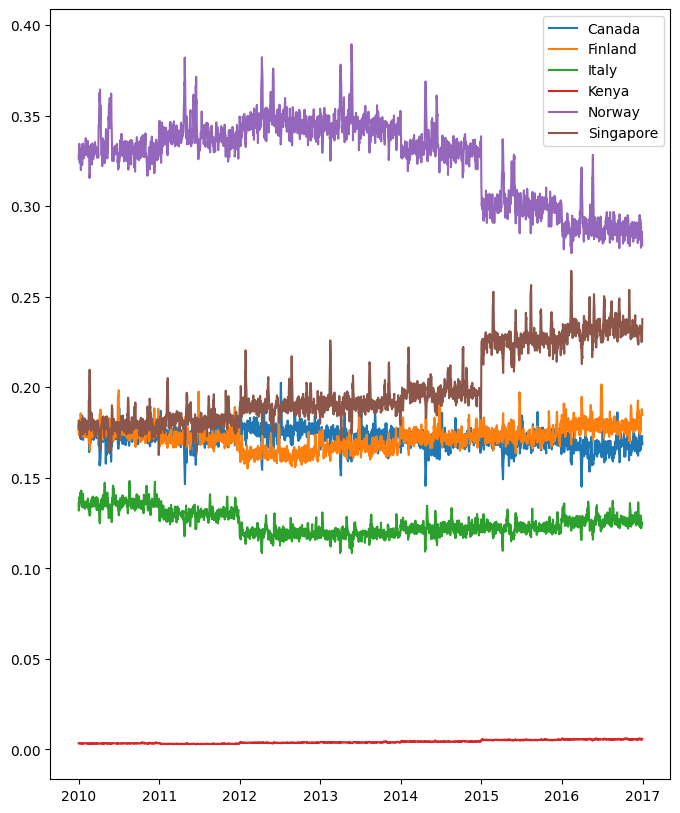

In [15]:
import requests

def decompose(train, c, ax):
    df = train.groupby(['date',c])[['num_sold']].sum().reset_index().join(
                            train.groupby('date')[['num_sold']].sum(), on='date',rsuffix='_global')
    df['fractions'] = df['num_sold']/df['num_sold_global']
    for m in np.sort(df[c].unique()):
        mask = df[c]==m
        ax.plot(df[mask]['date'],df[mask]['fractions'],label=m)
    ax.legend(bbox_to_anchor=(1, 1))  

train=pd.read_csv('data/train.csv', parse_dates=['date'], index_col='id')


def get_gdp_per_capita(alpha3, year):
    url='https://api.worldbank.org/v2/country/{0}/indicator/NY.GDP.PCAP.CD?date={1}&format=json'
    response = requests.get(url.format(alpha3,year)).json()
    return response[1][0]['value']

df = train[['date', 'country']].copy()
alpha3s = ['CAN', 'FIN', 'ITA', 'KEN', 'NOR', 'SGP']
df['alpha3'] = df['country'].map(dict(zip(
    np.sort(df['country'].unique()), alpha3s)))
years = np.sort(df['date'].dt.year.unique())
df['year'] = df['date'].dt.year
gdp = np.array([
    [get_gdp_per_capita(alpha3, year) for year in years]
    for alpha3 in alpha3s
])
gdp = pd.DataFrame(gdp/gdp.sum(axis=0), index=alpha3s, columns=years)
df['GDP'] = df.apply(lambda s: gdp.loc[s['alpha3'], s['year']], axis=1)

_, ax = plt.subplots(figsize=(8,10))
decompose(train, 'country', ax)
for country in df['country'].unique():
    mask = df['country']==country
    # ax.plot(df[mask]['date'],df[mask]['GDP'],'k--')
plt.show()


In [14]:
df

,date,country,alpha3,year,GDP
id,,,,,
0,2010-01-01,Canada,CAN,2010,0.178301
1,2010-01-01,Canada,CAN,2010,0.178301
2,2010-01-01,Canada,CAN,2010,0.178301
3,2010-01-01,Canada,CAN,2010,0.178301
4,2010-01-01,Canada,CAN,2010,0.178301
...,...,...,...,...,...
230125,2016-12-31,Singapore,SGP,2016,0.231100
230126,2016-12-31,Singapore,SGP,2016,0.231100
230127,2016-12-31,Singapore,SGP,2016,0.231100


In [16]:
train

,date,country,store,product,num_sold
id,,,,,
0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0
...,...,...,...,...,...
230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0
230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0
230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0


In [17]:
train = train.join(df[['GDP']], how='left')


In [18]:
train

,date,country,store,product,num_sold,GDP
id,,,,,,
0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,0.178301
1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,0.178301
2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,0.178301
3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,0.178301
4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,0.178301
...,...,...,...,...,...,...
230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0,0.231100
230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0,0.231100
230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0,0.231100


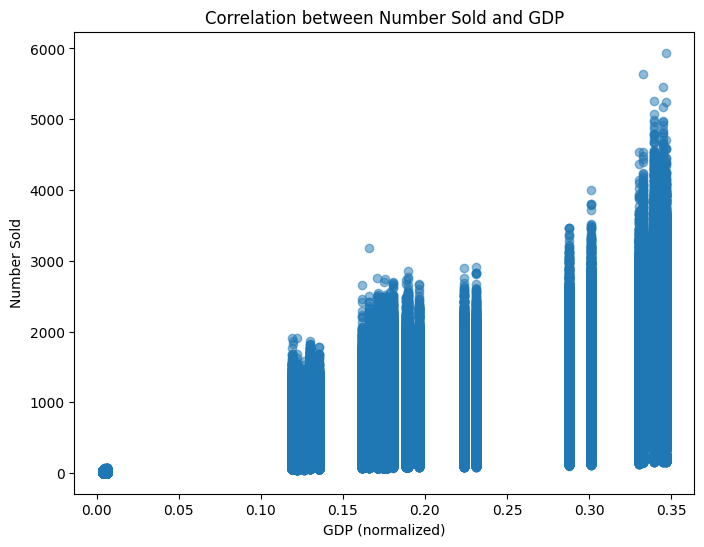

Correlation coefficient between Number Sold and GDP: 0.604


In [19]:
plt.figure(figsize=(8,6))
plt.scatter(train['GDP'], train['num_sold'], alpha=0.5)
plt.xlabel('GDP (normalized)')
plt.ylabel('Number Sold')
plt.title('Correlation between Number Sold and GDP')
plt.show()

# Print the correlation coefficient
print(f"Correlation coefficient between Number Sold and GDP: {train['num_sold'].corr(train['GDP']):.3f}")


In [22]:
# Split features and target
X = train.drop(['num_sold', 'date'], axis=1)
y = train['num_sold']

# Set up 5-fold cross validation
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
mse_scores = []
rmse_scores = []
mae_scores = []
r2_scores = []
feature_importances = []

# Perform k-fold cross validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Train model
    model = xgb.XGBRegressor(random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_val)
    
    # Calculate metrics
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    # Store metrics
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    feature_importances.append(model.feature_importances_)
    
    print(f"\nFold {fold+1} Metrics:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"R-squared Score: {r2:.2f}")

# Print average metrics across all folds
print("\nAverage Metrics Across All Folds:")
print(f"Mean Squared Error: {np.mean(mse_scores):.2f} (+/- {np.std(mse_scores):.2f})")
print(f"Root Mean Squared Error: {np.mean(rmse_scores):.2f} (+/- {np.std(rmse_scores):.2f})")
print(f"Mean Absolute Error: {np.mean(mae_scores):.2f} (+/- {np.std(mae_scores):.2f})")
print(f"R-squared Score: {np.mean(r2_scores):.2f} (+/- {np.std(r2_scores):.2f})")

# Average feature importance across folds
avg_importance = np.mean(feature_importances, axis=0)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': avg_importance
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('XGBoost Average Feature Importance Across 5 Folds')
plt.show()

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:country: object, store: object, product: object